In [1]:
import pandas as pd
import numpy as np
import os
import csv
import matplotlib.pyplot as plt
import hvplot.pandas
from pathlib import Path
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

csv_data = os.path.join(".","Border_Crossing_Entry_Data.csv")

border_df = pd.read_csv(csv_data)

border_df['Date'] = pd.to_datetime(border_df['Date'].str.strip(), errors='coerce')

In [2]:
#Drop any NAs
border_df = border_df.dropna(subset=['Date'])

#extract the 'year'
border_df['Year'] = border_df['Date'].dt.year

#remove any zeros
border_df = border_df.dropna(subset = ['Value'])
border_df = border_df[border_df['Value'] > 0]

#group by year and port
annual_data = border_df.groupby(['Year', 'Port Name'], as_index=False)['Value'].sum()

annual_data

Year       Port Name    Value
0     1996           Alcan   207758
1     1996  Alexandria Bay  2949709
2     1996         Ambrose    19312
3     1996         Andrade  3551780
4     1996          Antler    39888
...    ...             ...      ...
3129  2024        Westhope    15179
3130  2024        Whitlash     1297
3131  2024       Wildhorse    31143
3132  2024    Willow Creek     9633
3133  2024          Ysleta  9743869

[3134 rows x 3 columns]

In [3]:
#Sort the dat
annual_data = annual_data.sort_values(by=['Port Name', 'Year'])

#create a column for change from year to year
annual_data['Annual Change'] = annual_data.groupby('Port Name')['Value'].pct_change()

annual_data

Year Port Name     Value  Annual Change
0     1996     Alcan    207758            NaN
101   1997     Alcan    201656      -0.029371
204   1998     Alcan    261214       0.295345
307   1999     Alcan    232304      -0.110676
410   2000     Alcan    217178      -0.065113
...    ...       ...       ...            ...
2692  2020    Ysleta   5236686            NaN
2801  2021    Ysleta   8908054       0.701086
2912  2022    Ysleta  11209264       0.258329
3023  2023    Ysleta  12377010       0.104177
3133  2024    Ysleta   9743869      -0.212745

[3134 rows x 4 columns]

In [4]:
#create column which can be used to predict increase or decrease
annual_data = annual_data.dropna(subset=['Annual Change'])

annual_data['Increase'] = (annual_data['Annual Change'] > 0).astype(int)

C:\Users\mhennessy\AppData\Local\Temp\ipykernel_2504\1624508976.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  annual_data['Increase'] = (annual_data['Annual Change'] > 0).astype(int)


In [5]:
# Drop rows with na in annual change or increase
annual_data = annual_data.dropna(subset=['Annual Change', 'Increase'])

In [6]:
# Select features and target
X = annual_data['Year'].values.reshape(-1, 1)
y = annual_data['Increase']

In [7]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#create, fit, and predict model
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

y_pred_converted = (y_pred > 0.5).astype(int)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred_converted)
print(f'Accuracy: {accuracy:.4f}')
print("\nClassification Report:")
print(classification_report(y_test, y_pred_converted))

Accuracy: 0.5596

Classification Report:
              precision    recall  f1-score   support

           0       0.56      1.00      0.72       338
           1       0.00      0.00      0.00       266

    accuracy                           0.56       604
   macro avg       0.28      0.50      0.36       604
weighted avg       0.31      0.56      0.40       604



C:\Users\mhennessy\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mhennessy\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mhennessy\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


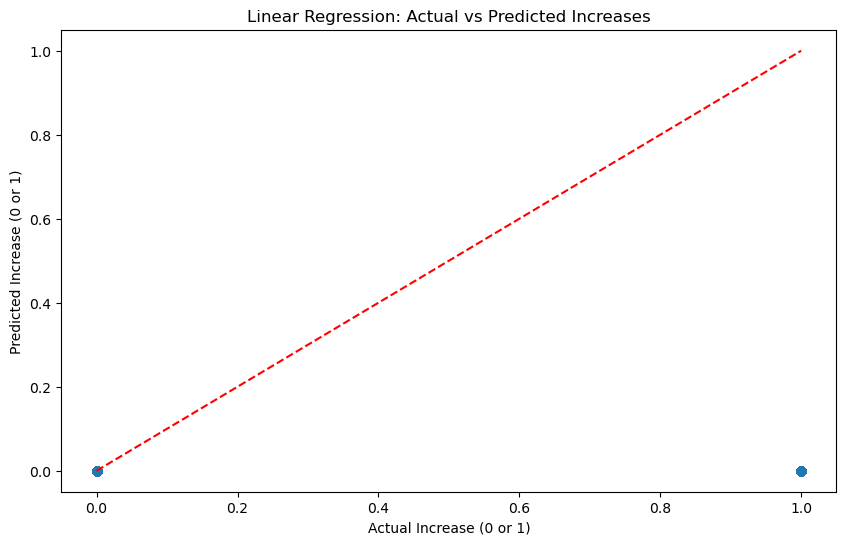

In [9]:
# Plot the model's predictions vs. actual outcomes
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred_converted, alpha=0.7)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('Actual Increase (0 or 1)')
plt.ylabel('Predicted Increase (0 or 1)')
plt.title('Linear Regression: Actual vs Predicted Increases')
plt.show()